# GIC Linear Model

Explores the internal structure of the GIC linear model built by
`pw.gic.model()`. The notebook covers GIC configuration, construction
of the G-matrix (conductance Laplacian) and H-matrix (linear mapping
from induced voltages to transformer neutral currents), comparison
with PowerWorld's own G-matrix, and storm application with result
validation.

In [ ]:
import numpy as np
from esapp import PowerWorld
from esapp.components import Bus, Branch, Substation, GICXFormer
from examples.map import format_plot

In [ ]:
# This cell is hidden in the documentation.
import ast

with open('../data/case.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

pw = PowerWorld(case_path)

In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_spy_matrices, plot_gmatrix_comparison,
    plot_gic_bar_hist,
)

## GIC Configuration

Before building a GIC model, configure the GIC options. The `configure()` method
sets sensible defaults.

In [ ]:
pw.gic.configure(pf_include=True, ts_include=False, calc_mode='SnapShot')

pw.gic.settings()

## 2. Building the GIC Model

The `model()` method extracts substation, bus, branch, transformer, and generator
data from the case and computes all GIC matrices.

In [ ]:
pw.gic.model()

print(f"Incidence matrix (A): {pw.gic.A.shape}  (branches x nodes)")
print(f"G-matrix:             {pw.gic.G.shape}  (nodes x nodes)")
print(f"H-matrix:             {pw.gic.H.shape}  (transformers x branches)")
print(f"Zeta (per-unit):      {pw.gic.zeta.shape}")
print(f"Effective operator:   {pw.gic.eff.shape}")
print(f"Bus permutation (Px): {pw.gic.Px.shape}")

## 3. Matrix Sparsity Patterns

Visualize the sparsity structure of the GIC matrices using spy plots.

In [ ]:
plot_spy_matrices(
    [pw.gic.A, pw.gic.G, pw.gic.H],
    [f'Incidence Matrix A\n{pw.gic.A.shape}, nnz={pw.gic.A.nnz}',
     f'G-Matrix (Conductance Laplacian)\n{pw.gic.G.shape}, nnz={pw.gic.G.nnz}',
     f'H-Matrix (GIC Function)\n{pw.gic.H.shape}, nnz={pw.gic.H.nnz}'])

## 5. Storm Application and GIC Results

Apply a uniform electric field storm and examine the resulting transformer GICs.

In [ ]:
# Apply 1 V/km eastward storm
pw.gic.storm(1.0, 90)

gic_results = pw[GICXFormer, ['BusNum3W', 'BusNum3W:1', 'GICXFNeutralAmps']]
gic_sorted = gic_results.reindex(
    gic_results['GICXFNeutralAmps'].abs().sort_values(ascending=False).index
)

print(f"Total transformers: {len(gic_results)}")
print(f"Max |GIC|: {gic_results['GICXFNeutralAmps'].abs().max():.3f} A")
print(f"\nTop transformers:")
print(gic_sorted.head(10).to_string(index=False))

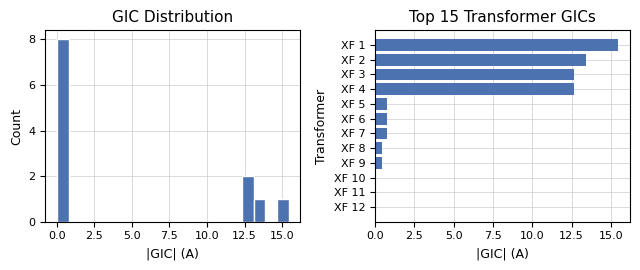

In [8]:
gic_abs = gic_results['GICXFNeutralAmps'].abs()
plot_gic_bar_hist(gic_abs)

## Per-Unit Zeta Model

The zeta matrix converts the linear GIC model to per-unit form, suitable
for integration into power flow studies. Each row represents a transformer's
contribution to reactive power losses.

In [ ]:
plot_spy_matrices(
    [pw.gic.zeta, pw.gic.Px],
    [f'Zeta Sparsity Pattern\n{pw.gic.zeta.shape}',
     f'Bus Permutation Matrix Px\n{pw.gic.Px.shape}'])

## Summary

The GIC model expresses transformer neutral currents as a linear function
of induced line voltages through the H-matrix. The G-matrix is a
conductance Laplacian ($A^T G_d A + G_s$), and the per-unit zeta matrix
enables integration with power flow studies. The Px permutation matrix
maps transformers to their loss-modeling buses.